# Second model 
- Refactor pre-processing and pipeline code into '../lib'
- For now, use **RandomForestClassifier** because it's fairly quick, and has comparable performance according to **2018_09_12_compare_algorithms.ipynb** and therefore is good for testing new feature engineering, etc

# TODO - 
- more complex pipeline components. Good example of parallel FeatureUnion
http://scikit-learn.org/stable/auto_examples/hetero_feature_union.html#sphx-glr-auto-examples-hetero-feature-union-py

## Features to engineer
- PCA or other dimensionality reduction on all the housing material features

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.externals import joblib

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from lib.pipeline import kfold, f1_scorer, FeatureExtractor, LazyProcessing
from lib.visualization import plot_confusion_matrix, plot_learning_curve

In [5]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

## Important: 
According to the competition (https://www.kaggle.com/c/costa-rican-household-poverty-prediction/discussion/61403), **ONLY heads of household are used in the scoring**. So we should only fit and evaluate our model on these observations (though in preprocessing we may use all individuals in household-level feature engineering). 
We do, however, need to keep all test data observations for submission. (here is a kernel showing some exploration of discrepancy of labels within households and some individuals without a head of household, but should be irrelevant if we only train on heads https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough)

In [6]:
test_features = ['meaneduc', 'no_primary_education', 'hh_max_rez_esc_scaled'] + [
    'wall_quality', 'roof_quality', 'floor_quality', 'house_material_vulnerability'] + [
    'house_utility_vulnerability', 'sanitario1', 'pisonotiene', 'cielorazo', 'abastaguano', 'noelec', 'sanitario1'] + [
    'asset_index', 'v18q', 'v18q1', 'refrig', 'computer', 'television'] + [
    'tamviv', 'hogar_nin', 'overcrowding'] + [
    'calc_dependency', 'calc_dependency_bin'] + [
    'phones_pc', 'tablets_pc', 'rooms_pc', 'rent_pc'] + [
    'v2a1', 'v2a1_missing']

In [7]:
#NOTE - preprocessing has not yet been intelligently integrated into the pipeline
# It is possible to use the LazyProcessing transformer, but it is clunky and slow, 
# so for now I'll do manual preprocessing as a script
from lib.preprocessing import preprocess
X_train = preprocess(train).drop('Target', axis = 1).query('parentesco1 == 1') #try subsetting to ONLY train on head of household
X_test = preprocess(test)
y_train = train.query('parentesco1 == 1')['Target'] #try subsetting to ONLY train on head of household
X_train[test_features].head()

# X_train = train.drop('Target', axis = 1).query('parentesco1 == 1') #try subsetting to ONLY train on head of household
# X_test = test.copy()
# y_train = train.query('parentesco1 == 1')['Target'] #try subsetting to ONLY train on head of household

,meaneduc,no_primary_education,hh_max_rez_esc_scaled,wall_quality,roof_quality,floor_quality,house_material_vulnerability,house_utility_vulnerability,sanitario1,pisonotiene,...,hogar_nin,overcrowding,calc_dependency,calc_dependency_bin,phones_pc,tablets_pc,rooms_pc,rent_pc,v2a1,v2a1_missing
0,10.0,0,NaN,1,0,0,2,0,0,0,...,0,1.000000,0.0,0,1.00,0.00,3.00,190000.0,190000.0,0
1,12.0,0,NaN,1,1,1,0,0,0,0,...,0,1.000000,1.0,1,1.00,1.00,4.00,135000.0,135000.0,0
2,11.0,0,NaN,1,2,2,0,0,0,0,...,0,0.500000,1.0,1,0.00,0.00,8.00,0.0,0.0,0
5,11.0,0,0.090909,2,2,2,0,0,0,0,...,2,1.333333,1.0,1,0.75,0.25,1.25,45000.0,180000.0,0
8,10.0,0,0.200000,0,0,1,2,0,0,0,...,2,4.000000,1.0,1,0.25,0.00,0.50,32500.0,130000.0,0


### Feature Selection
We will automate feature selection, but let's first visualize the relationship between number of features and cross-validation scroing for a RandomForestClassifier. It seems to be a toss-up after around 10 features

Optimal number of features : 20


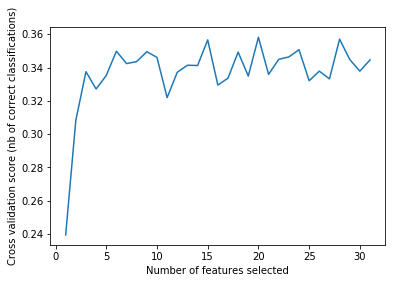

In [8]:
rfecv = RFECV(estimator=RandomForestClassifier(random_state=1, max_depth=15), step=1, cv=kfold,
              scoring=f1_scorer)

transformers = Pipeline(steps=[
                        ('feature_extraction', FeatureExtractor(test_features)),
                        ('imputer', Imputer(strategy = 'mean')),
                        ('feature_scaler', StandardScaler()),
                        # ('feature_selection', SelectFromModel(ExtraTreesClassifier())),
                        ])
X_transformed = transformers.fit_transform(X_train)
rfecv.fit(X_transformed, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [9]:
# For now do without ('processing', LazyProcessing())
full_pipeline = Pipeline(steps=[
                        ('feature_extraction', FeatureExtractor(test_features)),
                        ('imputer', Imputer(strategy = 'mean')),
                        ('feature_scaler', StandardScaler()),
                        ('feature_selection', SelectFromModel(ExtraTreesClassifier())),
                        ('random_forest', RandomForestClassifier(random_state = 1))])

In [10]:
%%time
DEPTHS = list(range(10,20))
param_grid = dict(random_forest__max_depth=DEPTHS)
grid = GridSearchCV(full_pipeline, param_grid=param_grid, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train, y_train)

# print(grid.cv_results_['mean_test_score'])
print(grid.best_params_)

{'random_forest__max_depth': 14}
Wall time: 6.05 s


In [11]:
%%time
model = grid.best_estimator_
model.fit(X_train, y_train)

Wall time: 93 ms


In [12]:
%%time
cv_score = cross_val_score(model, X_train, y_train, cv =kfold, scoring=f1_scorer, n_jobs=-1)
print(cv_score.mean())
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

0.35253263584032607
Cross Validation F1 Score = 0.3525 with std = 0.039
Wall time: 4.03 s


# Learning Curve
*YIKES*, given we aren't getting more data, we need to avoid such bad overfitting

Wall time: 5.13 s


<module 'matplotlib.pyplot' from 'c:\\users\\zrankin\\appdata\\local\\continuum\\miniconda3\\envs\\kaggle\\lib\\site-packages\\matplotlib\\pyplot.py'>

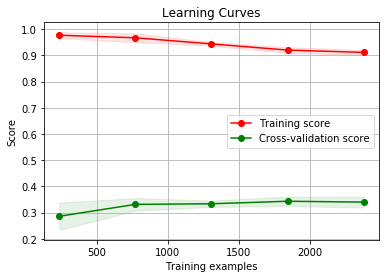

In [13]:
%%time
plot_learning_curve(model, 'Learning Curves', X_train, y_train, cv=kfold, scoring=f1_scorer)

In [14]:
estimator = model.steps[-1][1]

# WARNING - need to fix for automated feature selection, as column names/orders are not preserved
# feature_importances = pd.DataFrame({'feature': test_features, 'importance': estimator.feature_importances_})
# feature_importances.sort_values('importance', ascending=False)

estimator.feature_importances_

array([0.20332381, 0.05373518, 0.04260724, 0.04679181, 0.05538207,
       0.05033983, 0.05364793, 0.07599869, 0.08989323, 0.10427806,
       0.10176909, 0.05763008, 0.06460298])

# Submission

In [15]:
# Save model for error analysis (other notebook)
joblib.dump(model, '../models/random_forest.pkl')

# model = joblib.load('../models/random_forest.pkl')

['../models/random_forest.pkl']

In [16]:
y_pred = model.predict(X_test)
# plt.hist(y_pred)

In [17]:
y_pred_series = pd.Series(y_pred, name = 'Target')
submission = pd.concat([X_test['Id'], y_pred_series], axis=1)

In [18]:
submission.to_csv('../submission.csv', index=None)

In [19]:
submission.head()

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,4


## Error Analysis

In [20]:
y_train_predict = cross_val_predict(model, X_train, y_train, cv = kfold)

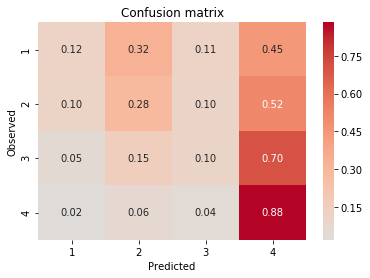

In [21]:
plot_confusion_matrix(y_train, y_train_predict, xticklabels = [1,2,3,4], yticklabels=[1,2,3,4])